In [1]:
import numpy as np
from scipy.linalg import eigh
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [2]:
pulses = {}

# declare type
Pulse = namedtuple('Pulse', ['time', 'field', 'interp_field'])

# save index where the field reseaches its maximum
peak_position = {}

for freq in range(4, 9):
    data = np.loadtxt(
        'experimental data 15-12-2021/PPLN_f0{}_400uJ_xavg.txt'.format(freq)
    )
    time, field = data.T
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"
    
    label = '0.{} THz'.format(freq)
    
    # Relabel time axis such that peak field is at zero time 
    indx = np.abs(field).argmax()
    peak_position[label] = indx
    time -= time[indx] 
        
    pulses[label] = Pulse(
        time, 
        field, 
        UnivariateSpline(time, field, ext='zeros', s=0)
    )

# saving the largest frequency
largest_freq = label

### Remove 0.4 THz from the analysis

In [3]:
del pulses['0.4 THz']

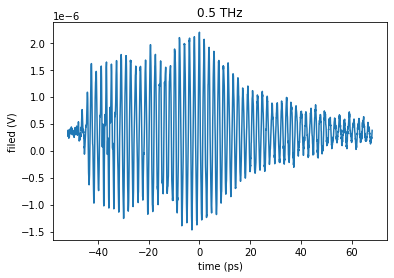

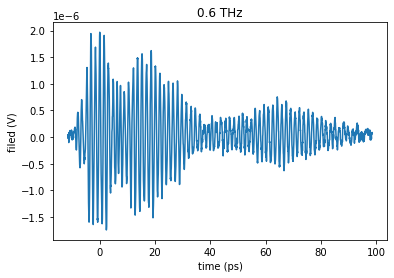

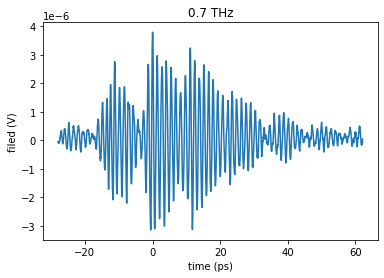

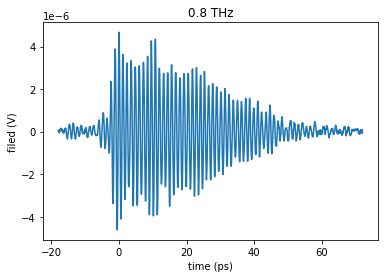

In [4]:
# Plot pulses
for freq, data in pulses.items():
    plt.title(freq)
    plt.plot(data.time, data.field)
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

### Manually extract observational time window 

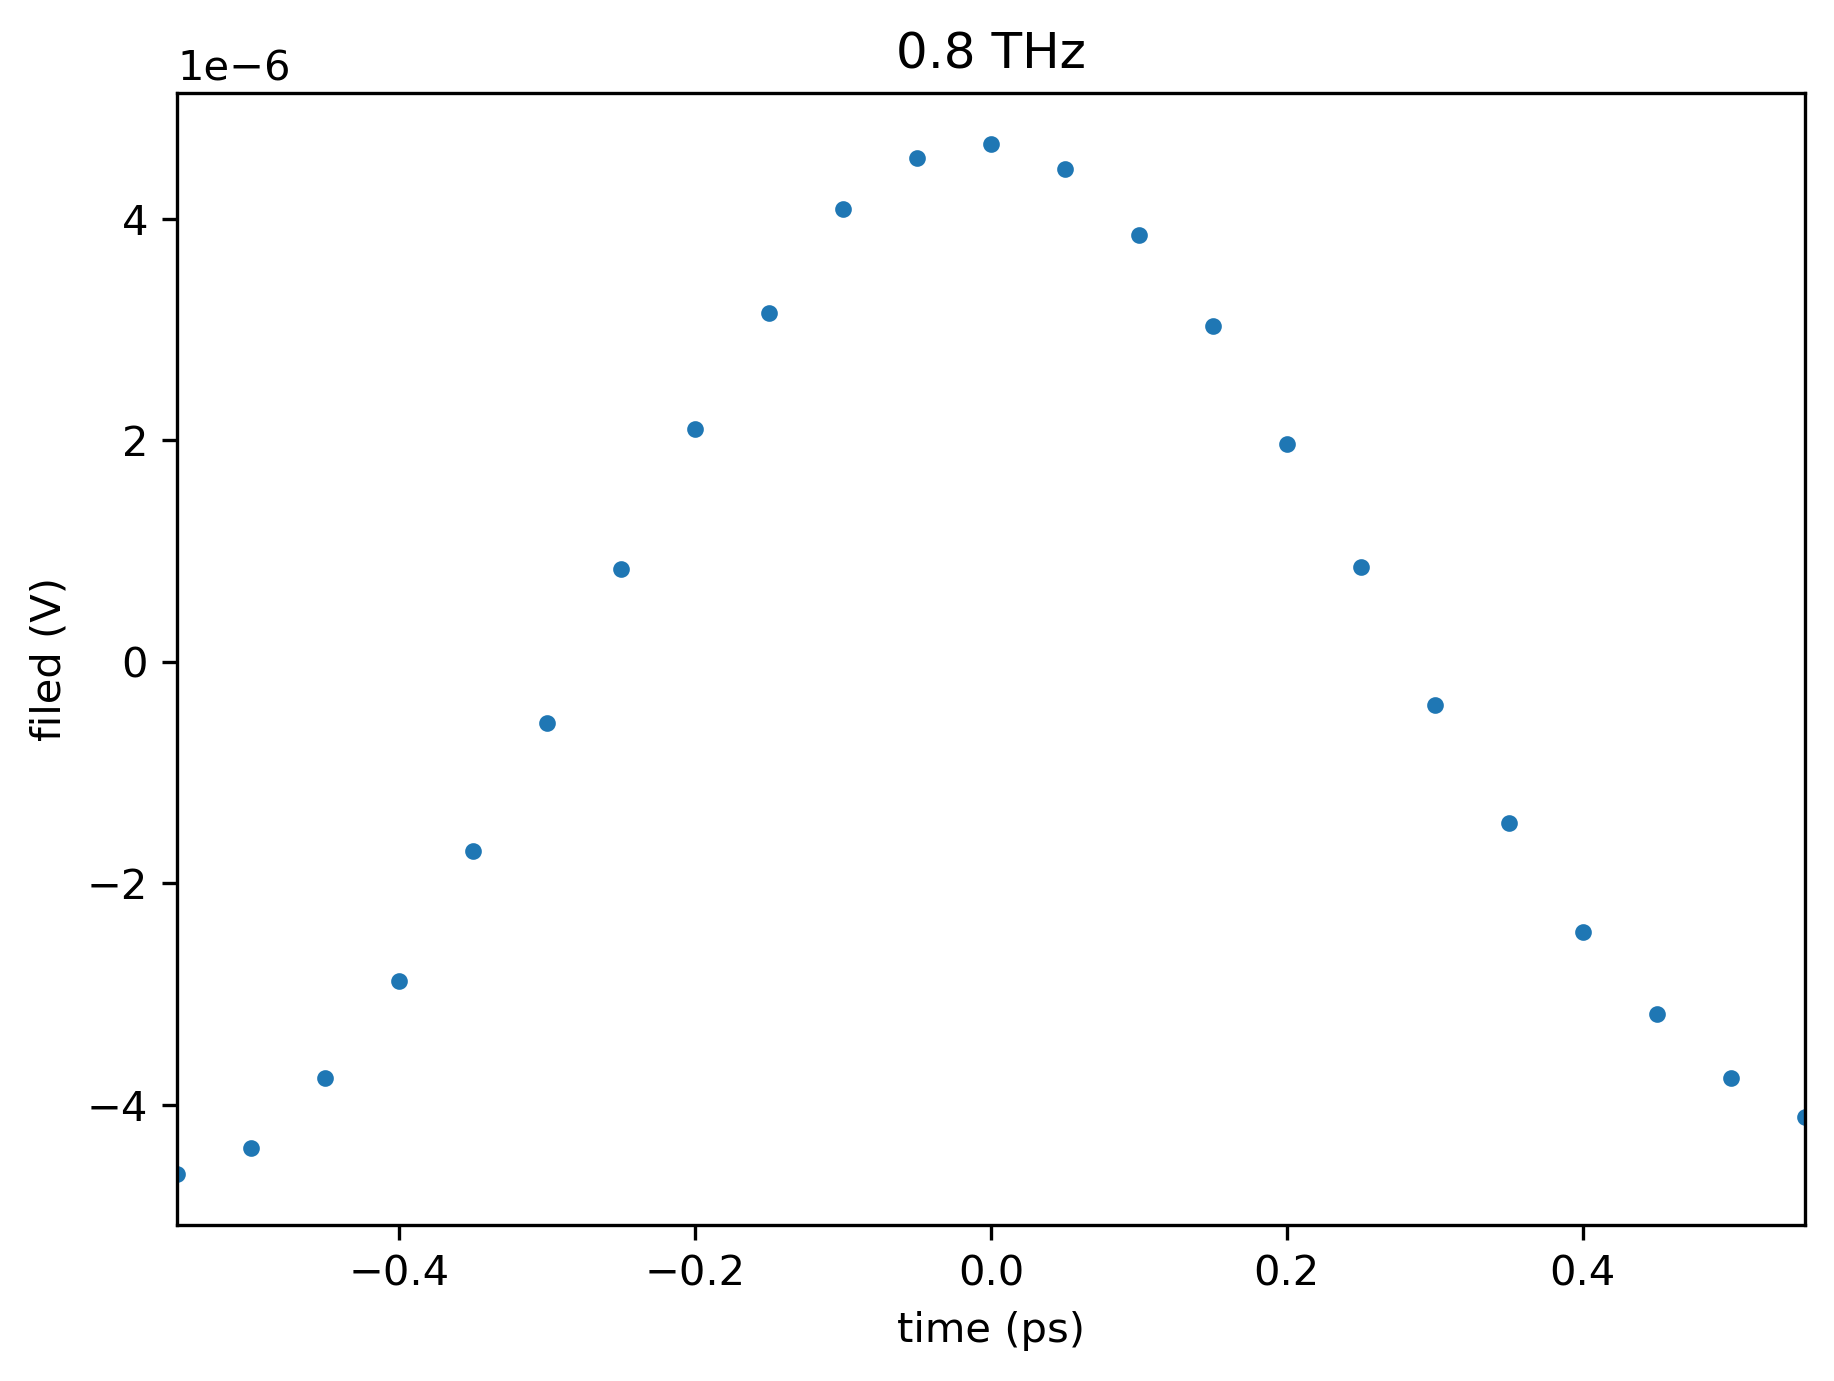

In [5]:
plt.figure(figsize=(7, 5), dpi=300)
    
time, field, _ = pulses[largest_freq]
plt.plot(time, field, '.')

indx = peak_position[largest_freq]

observational_window = time[indx - 11], time[indx + 11]

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

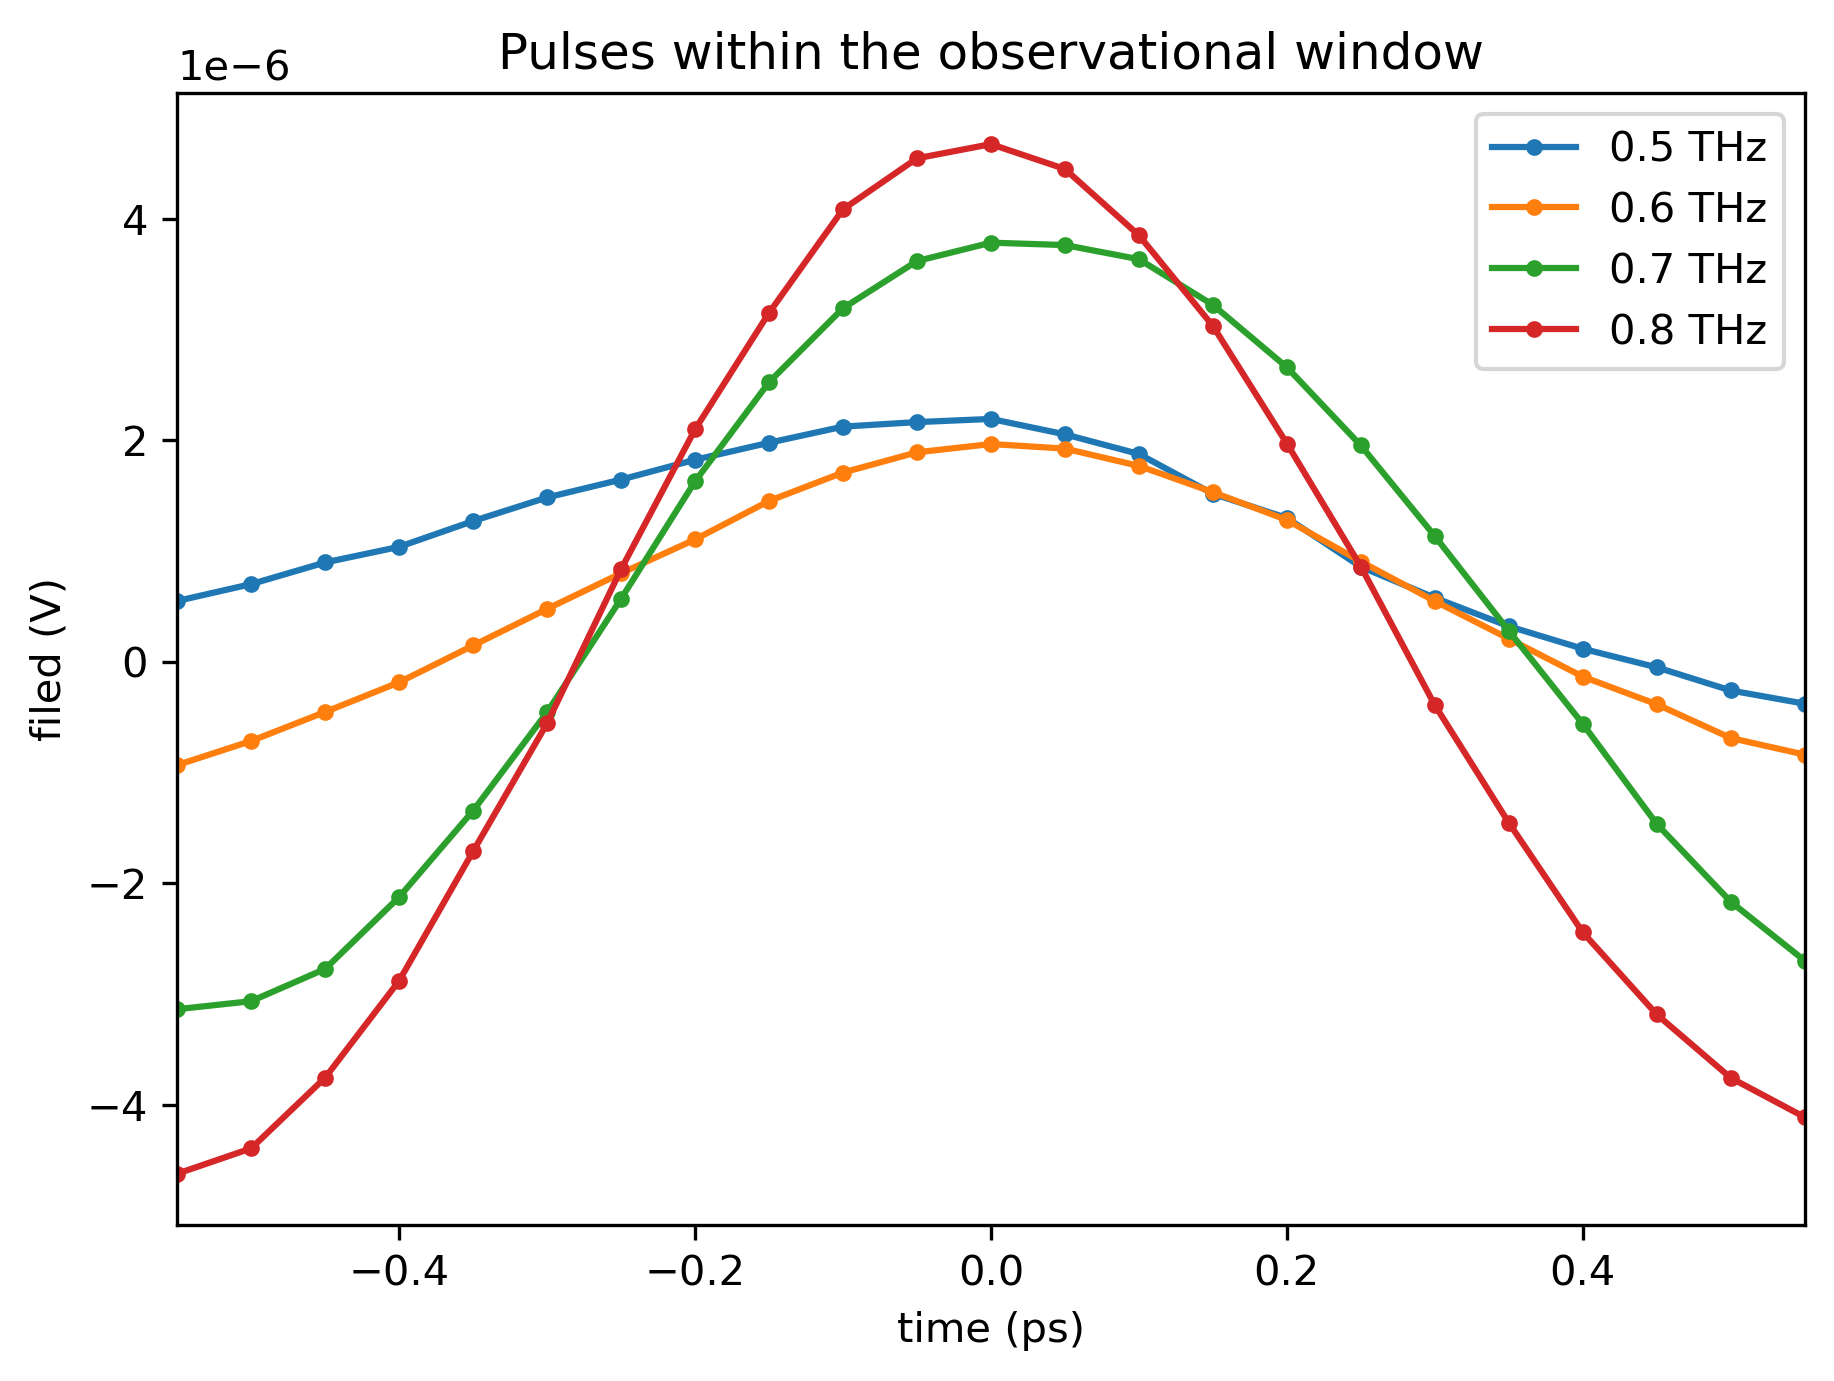

In [6]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, (time, field, interp_field) in pulses.items():
    plt.plot(time, field, '.-', label=freq)
    
    plt.xlim(np.array(observational_window))
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')

plt.legend()
plt.show()  

# Synthesizing superoscillations 

The first step, Calculate the overlap matrix
$$
 S_{ij}(t_1, t_2) = \int_{t_1}^{t_2} E_i(t) E_j(t) dt
$$

In [7]:
def get_overlap(pulse1, pulse2, int_bounds):
    
    # common time axis
    t = np.union1d(pulse1.time, pulse2.time)
    
    return UnivariateSpline(
        t, 
        pulse1.interp_field(t) * pulse2.interp_field(t), 
        ext='zeros', 
        s=0
    ).integral(*int_bounds)

Get $S_{ij}(-\infty, \infty)$

In [8]:
S_infty = [
    [
        get_overlap(pulse1, pulse2, (-np.inf, np.inf)) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_infty = np.array(S_infty)

assert np.allclose(S_infty, S_infty.T)

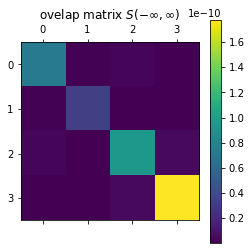

In [9]:
plt.matshow(np.abs(S_infty))
plt.colorbar()
plt.title("ovelap matrix $S(-\infty, \infty)$")
plt.show()

Get overlap matrix for the observational window

In [10]:
S_observ = [
    [
        get_overlap(pulse1, pulse2, observational_window) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_observ = np.array(S_observ)

assert np.allclose(S_observ, S_observ.T)

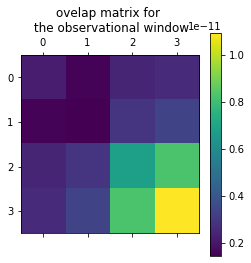

In [11]:
plt.matshow(np.abs(S_observ))
plt.colorbar()
plt.title("ovelap matrix for \n the observational window")
plt.show()

### Finding optimal strategies for generating supperoscilations via eigenvectors

In [12]:
vals, vecs = eigh(S_observ, S_infty)

# Ploting superoscilations

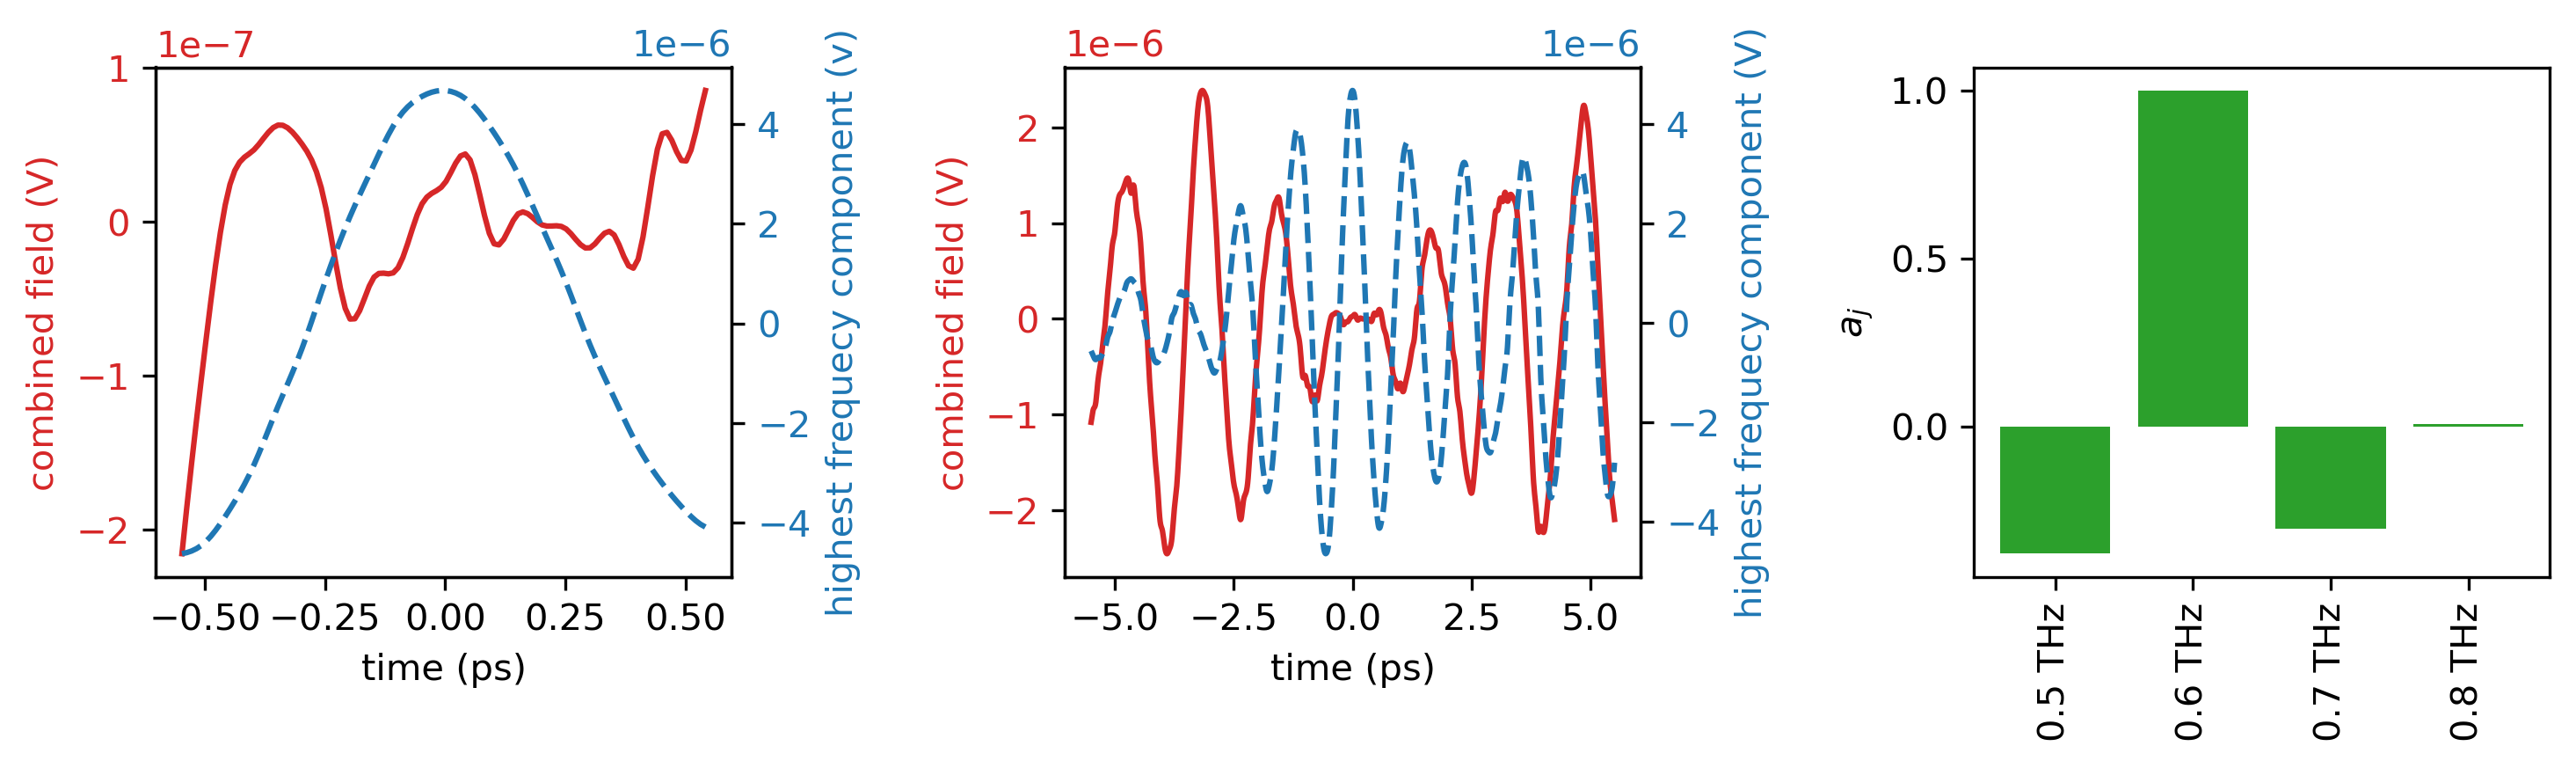

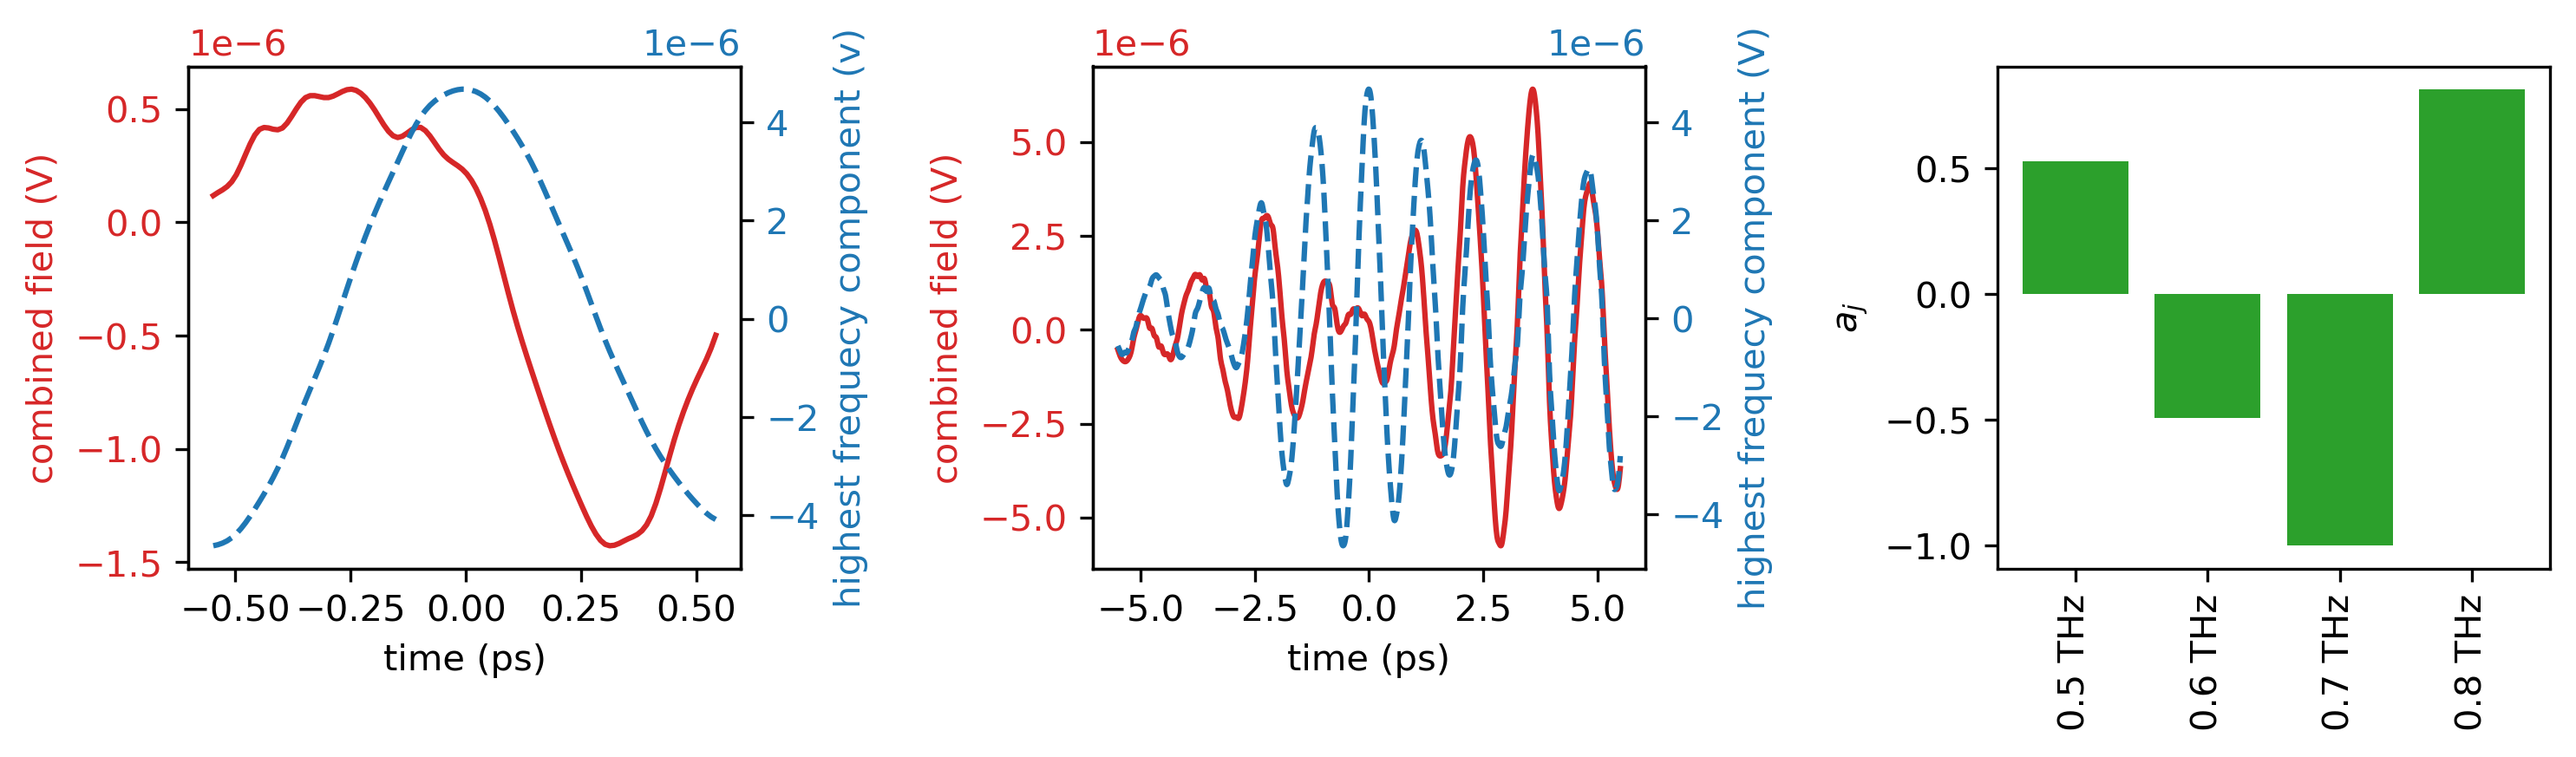

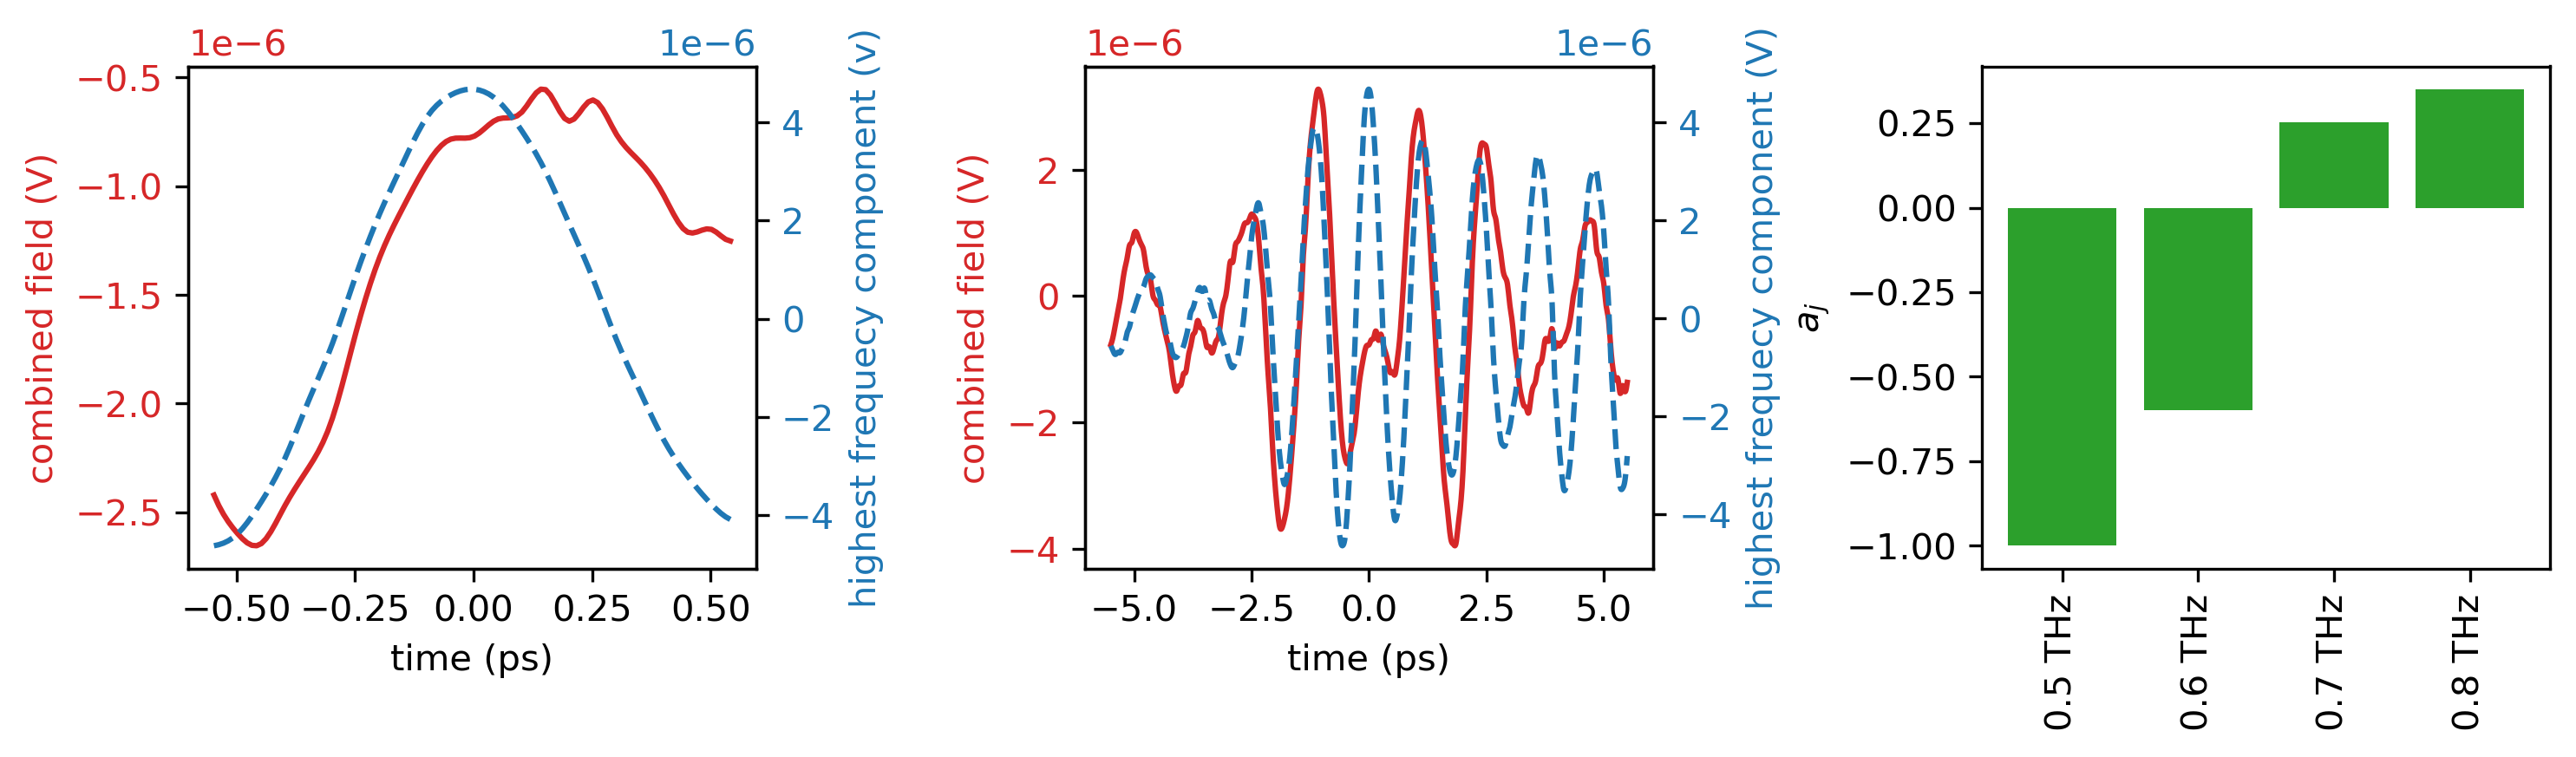

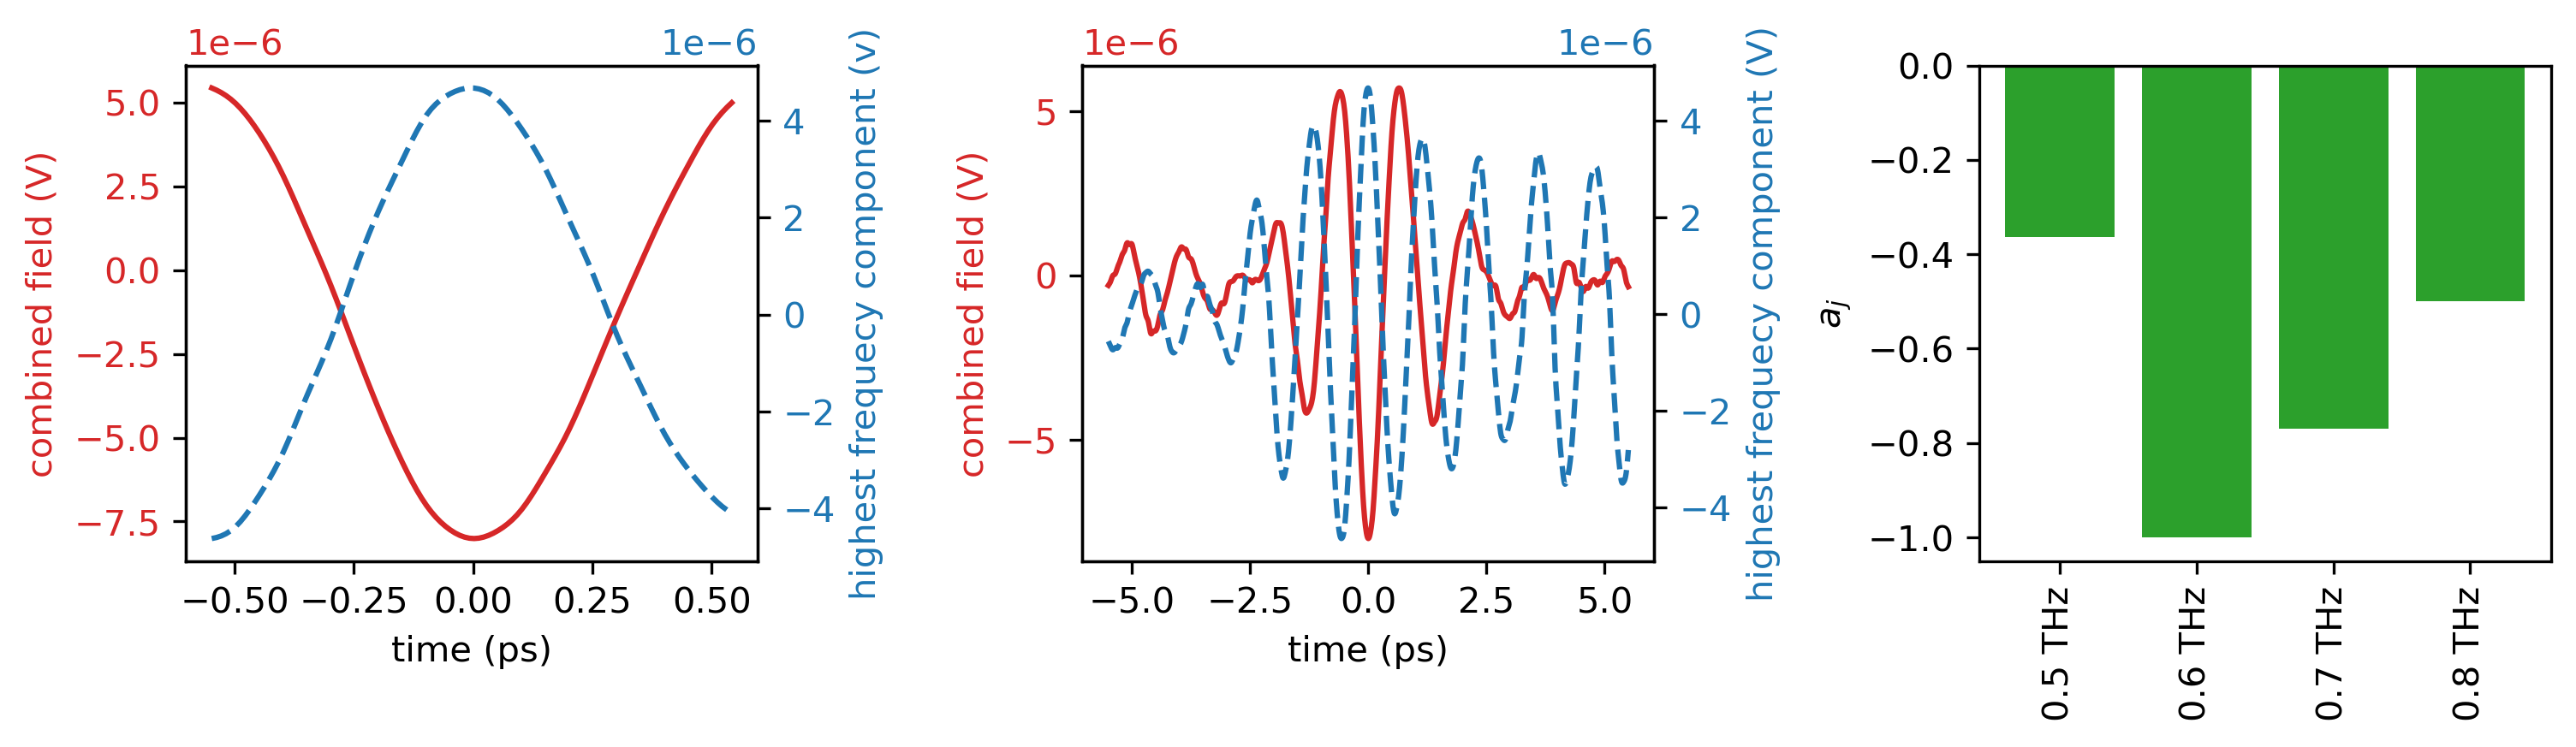

In [16]:
# Use refined time axis for the largest frequency component
fastest = pulses[largest_freq]
t = fastest.time
t = np.linspace(t.min(), t.max(), 5 * t.size)

# extract indices of the observational window
ow1 = np.searchsorted(t, observational_window[0], side='left')
ow2 = np.searchsorted(t, observational_window[1], side='right')

# extract indices of the largest window
Lw1 = np.searchsorted(t, 10 * observational_window[0], side='left')
Lw2 = np.searchsorted(t, 10 * observational_window[1], side='right')

for num, eig_vector in enumerate(vecs.T):
    
    # a sanity check
    assert np.allclose(eig_vector.T @ S_infty @ eig_vector, 1.)
    
    # Normalizing amplitudes
    eig_vector = eig_vector / np.abs(eig_vector).max()
    
    # get superoscilating fields
    field = sum(
        c * _.interp_field(t) for c, _ in zip(eig_vector, pulses.values())
    )
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t[ow1:ow2], field[ow1:ow2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (v)', color=color2)
    ax2.plot(t[ow1:ow2], fastest.interp_field(t[ow1:ow2]), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(observational_window)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot zoom out view
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t[Lw1:Lw2], field[Lw1:Lw2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (V)', color=color2)
    ax2.plot(t[Lw1:Lw2], fastest.interp_field(t[Lw1:Lw2]), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(10 * np.array(observational_window))
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(pulses, rotation='vertical')
    #ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.png'.format(num), transparent=True)
    
    plt.show()